# Descrição dos dados

``EventName`` — nome do evento

``DeviceIDHash`` — identificador de usuário exclusivo

``EventTimestamp`` — hora do evento

``ExpId`` — número do experimento: 246 e 247 são os grupos de controle, 248 é o grupo de teste

In [129]:
# Importando bibliotecas.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest as pz

In [130]:
# Carregando a tabela de dados.
try:
    df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

except:
    df = pd.read_csv(r"C:\Users\cassi\GitHub\Projeto11__Tripleten-Bootcamp\Dados\logs_exp_us.csv", sep='\t')

In [131]:
# Verificando informações da tabela de dados.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [132]:
# Carregando uma amostra dos dados.
df.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
76547,MainScreenAppear,3025649757727336502,1564808939,246
2772,MainScreenAppear,1615677818169862243,1564614857,247
132251,OffersScreenAppear,3783993475053044166,1564935696,247
41079,PaymentScreenSuccessful,6304868067479728361,1564714433,248
138065,MainScreenAppear,1351222438078767488,1564946622,246
147318,MainScreenAppear,8169912674018207278,1564991758,247
78225,CartScreenAppear,6179875053469512240,1564813995,247
233458,PaymentScreenSuccessful,1055544042902443290,1565190839,246
174009,MainScreenAppear,6483696045451304132,1565033183,247
134074,MainScreenAppear,8591672416652564856,1564938613,247


## Tratamento de dados

In [133]:
# Convertendo os dados para o tipo correto.
df['DeviceIDHash'] = df['DeviceIDHash'].astype('uint32')
df['ExpId'] = df['ExpId'].astype('uint8')
df['EventTimestamp'] = pd.to_datetime(df['EventTimestamp'], unit='s')

In [134]:
#  Convertendo os nomes das colunas para minúsculos.
def lowercase_columns(df):
    new_columns = [col.lower() for col in df.columns]
    df.columns = new_columns
    return df


df = lowercase_columns(df)
print(df.columns)   

Index(['eventname', 'deviceidhash', 'eventtimestamp', 'expid'], dtype='object')


In [135]:
# Corrigindo o espaçamento dos nomes das colunas.
new_names = {
    'eventname' : 'event_name',
    'deviceidhash': 'device_id_hash',
    'eventtimestamp': 'event_timestamp',
    'expid' : 'exp_id'
}
df.rename(columns=new_names, inplace=True)
print(df.columns)

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')


In [136]:
# Agregando novas colunas para dia, mês e ano.
df['day'] = df['event_timestamp'].dt.day
df['month'] = df['event_timestamp'].dt.month
df['date'] = df['event_timestamp'].dt.date
df['date'] = pd.to_datetime(df['date'])
df['time'] = df['event_timestamp'].dt.time
df['hour'] = df['event_timestamp'].dt.hour

In [137]:
# Carregando uma amostra dos dados após o tratamento.
df.sample(10)

,event_name,device_id_hash,event_timestamp,exp_id,day,month,date,time,hour
191715,OffersScreenAppear,36060601,2019-08-06 11:30:29,247,6,8,2019-08-06,11:30:29,11
88549,OffersScreenAppear,2094089985,2019-08-03 11:33:51,246,3,8,2019-08-03,11:33:51,11
86523,MainScreenAppear,455050711,2019-08-03 10:49:17,248,3,8,2019-08-03,10:49:17,10
184437,MainScreenAppear,554505566,2019-08-06 07:39:46,246,6,8,2019-08-06,07:39:46,7
181415,MainScreenAppear,3439116048,2019-08-06 05:53:09,248,6,8,2019-08-06,05:53:09,5
183042,MainScreenAppear,1999008718,2019-08-06 06:52:44,246,6,8,2019-08-06,06:52:44,6
101890,MainScreenAppear,1426076250,2019-08-03 17:19:35,246,3,8,2019-08-03,17:19:35,17
100666,PaymentScreenSuccessful,3365784642,2019-08-03 16:47:55,248,3,8,2019-08-03,16:47:55,16
27936,MainScreenAppear,3461697909,2019-08-01 16:02:35,247,1,8,2019-08-01,16:02:35,16
102578,CartScreenAppear,4268228514,2019-08-03 17:40:10,246,3,8,2019-08-03,17:40:10,17


In [138]:
# Carregando as informações dos dados após o tratamento.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  uint32        
 2   event_timestamp  244126 non-null  datetime64[ns]
 3   exp_id           244126 non-null  uint8         
 4   day              244126 non-null  int32         
 5   month            244126 non-null  int32         
 6   date             244126 non-null  datetime64[ns]
 7   time             244126 non-null  object        
 8   hour             244126 non-null  int32         
dtypes: datetime64[ns](2), int32(3), object(2), uint32(1), uint8(1)
memory usage: 11.4+ MB


## Estudo e verificação dos dados

In [139]:
# Verificando quantos eventos ficam nos registros.
num_eventos = df.shape[0]
print(f"Número total de eventos: {num_eventos}")

Número total de eventos: 244126


In [140]:
# Verificando quantos usuários ficam nos registros.
num_users = df['device_id_hash'].nunique()
print(f"Número total de usuários: {num_users}")

Número total de usuários: 7551


In [141]:
#  Verificando o número médio de eventos por usuário.
mean_events = df.groupby('device_id_hash')['event_name'].count().mean()
print(f"Número médio de eventos por usuário: {mean_events:.1f}")

Número médio de eventos por usuário: 32.3


In [142]:
# Verificando qual é o período de tempo que os dados cobrem e encontrando as datas máxima e mínima.
min_date = df['date'].min()
max_date = df['date'].max()

print(f"Período coberto pelos dados: de {min_date} até {max_date}")

Período coberto pelos dados: de 2019-07-25 00:00:00 até 2019-08-07 00:00:00


``Os dados englobam um período de tempo de 2 semanas! Começando pelo dia 25 do mês 7 (Julho) e finalizando no dia 7 do mês 8 (Agosto). ``

c:\Users\cassi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\cassi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


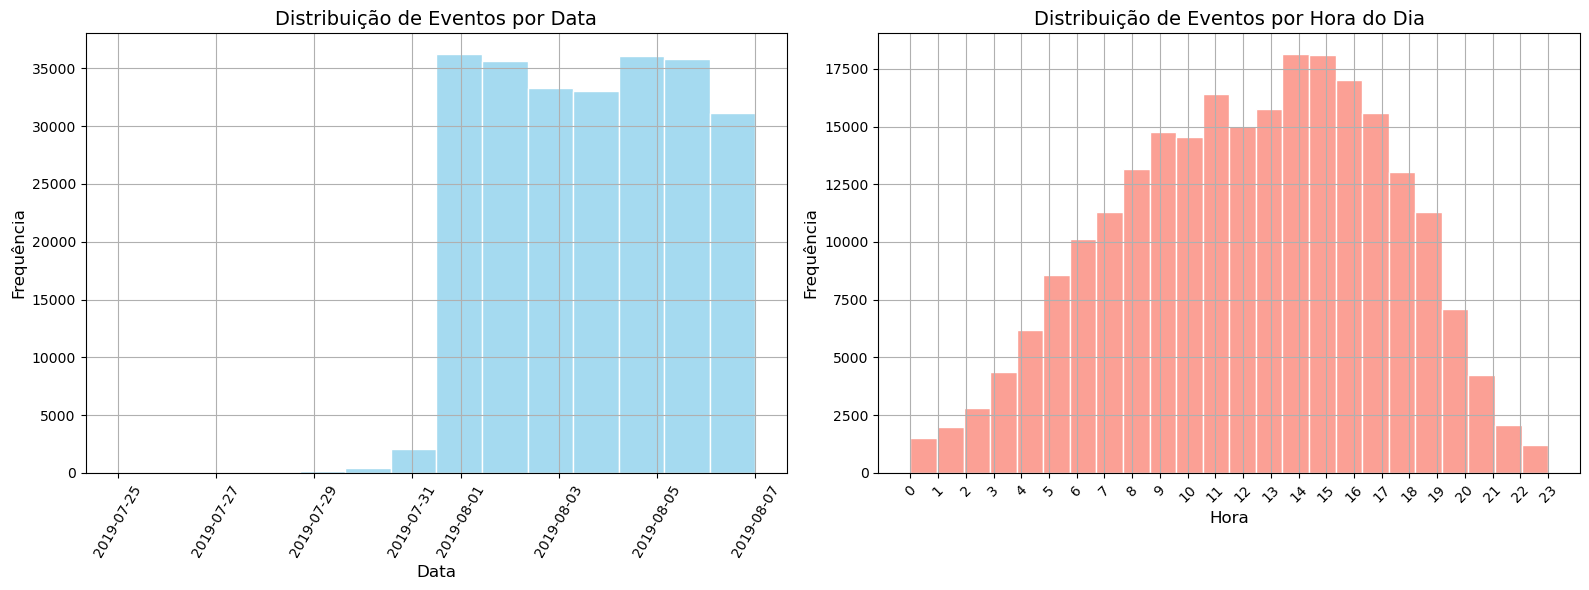

In [143]:
# Construindo um histograma por data e hora.
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Histograma por Data
sns.histplot(df['date'], bins=len(df['date'].unique()),kde=False, ax=ax[0], color='skyblue', edgecolor='white')
ax[0].set_title("Distribuição de Eventos por Data", fontsize=14)
ax[0].set_xlabel("Data", fontsize=12)
ax[0].set_ylabel("Frequência", fontsize=12)
ax[0].tick_params(axis='x', rotation=60)
ax[0].grid(True)

# Subplot 2: Histograma por Hora
sns.histplot(df['hour'], bins=24, kde=False, ax=ax[1],color='salmon', edgecolor='white')
ax[1].set_title("Distribuição de Eventos por Hora do Dia", fontsize=14)
ax[1].set_xlabel("Hora", fontsize=12)
ax[1].set_ylabel("Frequência", fontsize=12)
ax[1].set_xticks(range(0, 24))
ax[1].tick_params(axis='x', rotation=45)
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [144]:
# Encontrado o momento em que os dados começam a ser completos e ignorando a seção anterior.
start_date = '2019-08-01'
new_df = df[df['date'] >= start_date]

In [145]:
# Verificando qual período os dados realmente representam.
filtered_min_date = new_df['date'].min().date()
filtered_max_date = new_df['date'].max().date()

print(f'O novo período de cobrimento dos dados é {filtered_min_date} e , {filtered_max_date}')

O novo período de cobrimento dos dados é 2019-08-01 e , 2019-08-07


``Agora os dados englobam o período da primeira semana de agosto!``

In [146]:
# Verificando se muitos eventos e usuários foram perdidos ao excluir os dados mais antigos.
num_eventos_antes = df.shape[0]
num_usuarios_antes = df['device_id_hash'].nunique()

# Número de eventos e usuários após a filtragem
num_eventos_depois = new_df.shape[0]
num_usuarios_depois = new_df['device_id_hash'].nunique()

# Eventos e usuários perdidos
eventos_perdidos = num_eventos_antes - num_eventos_depois
usuarios_perdidos = num_usuarios_antes - num_usuarios_depois

print(f"Eventos perdidos: {eventos_perdidos}")
print(f"Usuários perdidos: {usuarios_perdidos}")

Eventos perdidos: 2828
Usuários perdidos: 17


In [147]:
# Verificando a presença de usuários de todos os três grupos experimentais.
present_groups = new_df['exp_id'].unique()
print(f"Grupos experimentais presentes nos dados: {present_groups}")

Grupos experimentais presentes nos dados: [246 247 248]


## Estudo do funil de eventos

In [148]:
# Confirmando quais eventos estão nos diários e sua frequência de ocorrência e classificando-os por frequência.
event_freq = new_df['event_name'].value_counts(sort=True, normalize=True).reset_index()
event_freq.columns = ['event_name', 'frequency']
event_freq['frequency'] = event_freq['frequency'].round(2)
event_freq

,event_name,frequency
0,MainScreenAppear,0.49
1,OffersScreenAppear,0.19
2,CartScreenAppear,0.18
3,PaymentScreenSuccessful,0.14
4,Tutorial,0.00


In [149]:
# Encontrando o número de usuários que executaram cada uma dessas ações e ordenando os eventos pelo número de usuários
actions_by_users = new_df.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False).reset_index()
actions_by_users.columns = ['event_name', 'users_actions']
actions_by_users

,event_name,users_actions
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [150]:
# Calculando a proporção de usuários que executaram a ação pelo menos uma vez.
nunique_users = new_df['device_id_hash'].nunique()
actions_by_users['users_proportion'] = actions_by_users['users_actions'] / nunique_users
actions_by_users[['event_name', 'users_proportion']].round(2)

,event_name,users_proportion
0,MainScreenAppear,0.98
1,OffersScreenAppear,0.61
2,CartScreenAppear,0.50
3,PaymentScreenSuccessful,0.47
4,Tutorial,0.11


In [151]:
# Verificando em que ordem as ações ocorreram para cada usuário. 
df_sorted = new_df.sort_values(by=['device_id_hash', 'event_timestamp'])

sample = df_sorted[df_sorted['device_id_hash'] == 820561199]  # Utilizar ID aleatório de usuario para verificar diferentes amostras.
sample[['device_id_hash', 'event_name', 'event_timestamp']].head(20).reset_index(drop=True)

,device_id_hash,event_name,event_timestamp
0,820561199,Tutorial,2019-08-05 05:47:35
1,820561199,MainScreenAppear,2019-08-05 05:48:35
2,820561199,MainScreenAppear,2019-08-05 05:48:58
3,820561199,OffersScreenAppear,2019-08-05 05:49:06
4,820561199,MainScreenAppear,2019-08-05 05:50:06
5,820561199,MainScreenAppear,2019-08-05 05:50:49
6,820561199,MainScreenAppear,2019-08-05 05:51:05
7,820561199,MainScreenAppear,2019-08-05 05:51:39
8,820561199,OffersScreenAppear,2019-08-05 05:53:29
9,820561199,CartScreenAppear,2019-08-05 05:53:44


In [152]:
# Verificando o número de ações e de eventos únicos para cada usuário.
total_actions = df_sorted.groupby('device_id_hash').agg(event_count=('event_name', 'count'), unique_events=('event_name', 'unique')).reset_index()
total_actions.head(15)

,device_id_hash,event_count,unique_events
0,443256,30,"[MainScreenAppear, OffersScreenAppear]"
1,448419,6,"[MainScreenAppear, OffersScreenAppear]"
2,520056,26,[MainScreenAppear]
3,1199970,6,"[MainScreenAppear, OffersScreenAppear]"
4,1241014,40,"[Tutorial, MainScreenAppear, CartScreenAppear,..."
5,1471703,8,[MainScreenAppear]
6,1542393,11,[MainScreenAppear]
7,2352070,33,"[CartScreenAppear, PaymentScreenSuccessful, Of..."
8,2574555,18,[MainScreenAppear]
9,3173707,26,[MainScreenAppear]


````

In [153]:
# Usando o funil de eventos para encontrar a parcela de usuários que passam de uma etapa para a próxima.
etapas_funil = ['Tutorial', 'MainScreenAppear', 'OffersScreenAppear','CartScreenAppear', 'PaymentScreenSuccessful']

funil = {}

df_teste = new_df.sort_values(by=['device_id_hash', 'event_timestamp'])

usuarios_anteriores = set(new_df['device_id_hash'].unique())

for etapa in etapas_funil:
    usuarios_atual = set(df_teste[df_teste['event_name'] == etapa]['device_id_hash'].unique())

    usuarios_passaram = usuarios_atual.intersection(usuarios_anteriores)

    funil[etapa] = len(usuarios_passaram)

    usuarios_anteriores = usuarios_passaram

funil_df = pd.DataFrame(list(funil.items()), columns=['etapa', 'num_users'])

funil_df['proporcao'] = funil_df['num_users'] / funil_df['num_users'].shift(1)

funil_df.loc[0, 'proporcao'] = 1

funil_df

,etapa,num_users,proporcao
0,Tutorial,840,1.000000
1,MainScreenAppear,836,0.995238
2,OffersScreenAppear,644,0.770335
3,CartScreenAppear,531,0.824534
4,PaymentScreenSuccessful,466,0.877589


In [154]:
# Calculando em qual fase se perde mais usuários.
etapa_maior_perda = funil_df[funil_df['proporcao'] == funil_df['proporcao'].min()]['etapa'].values[0]

print(f"A etapa onde mais usuários foram perdidos é: {etapa_maior_perda}")

A etapa onde mais usuários foram perdidos é: OffersScreenAppear


In [155]:
# Calculando qual é a parcela de usuários que faz o caminho inteiro, desde o primeiro evento até o pagamento.

usuarios_inicio = funil_df[funil_df['etapa'] == 'Tutorial']['num_users'].values[0]
usuarios_fim = funil_df[funil_df['etapa'] == 'PaymentScreenSuccessful']['num_users'].values[0]

parcela_completa = usuarios_fim / usuarios_inicio

print(f"A parcela de usuários que completaram o funil inteiro é: {parcela_completa:.2%}")

A parcela de usuários que completaram o funil inteiro é: 55.48%


 ## Estudo dos resultados do experimento

In [156]:
# Calculando quantos usuários há em cada grupo.
users_per_group = new_df.groupby('exp_id')['device_id_hash'].nunique().reset_index()
users_per_group.columns = ['exp_group','users_num'] 
users_per_group

,exp_group,users_num
0,246,2484
1,247,2513
2,248,2537


In [157]:
# Temos dois grupos de controle no teste A/A, no qual verificamos nossos mecanismos e cálculos. Veja se há uma diferença estatisticamente significativa entre as amostragens 246 e 247.
# Hipótese nula: As médias dos grupos 246 e 247 são iguais.
# Hipótese alternativa: As médias dos grupos 246 e 247 são diferentes.

group_246 = new_df[new_df['exp_id'] == 246]
group_247 = new_df[new_df['exp_id'] == 247]

events_per_users_246 = group_246.groupby('device_id_hash')['event_name'].count()
events_per_users_247 = group_247.groupby('device_id_hash')['event_name'].count()

t_stat, p_value = st.ttest_ind(events_per_users_246, events_per_users_247)

print(f"Estatística t: {t_stat}")
print(f"Valor p: {p_value}")

if p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos 246 e 247.")
else:
    print("Não há uma diferença estatisticamente significativa entre os grupos 246 e 247.")

Estatística t: 0.7407740332387146
Valor p: 0.4588652825514783
Não há uma diferença estatisticamente significativa entre os grupos 246 e 247.


In [158]:
# Selecione o evento mais popular. Em cada um dos grupos de controle, encontre o número de usuários que realizaram essa ação. Encontre a proporção deles. Verifique se a diferença entre os grupos é estatisticamente significativa. Repita o procedimento para todos os outros eventos (economizará tempo se você criar uma função especial para este teste). Você pode confirmar se os grupos foram divididos corretamente?

# Função para testar a diferença estatística entre dois grupos para um evento específico
def testar_evento(event_name, grupo_1, grupo_2):
    # Contar o número de usuários que realizaram o evento em cada grupo
    users_grupo_1 = grupo_1[grupo_1['event_name'] == event_name]['device_id_hash'].nunique()
    users_grupo_2 = grupo_2[grupo_2['event_name'] == event_name]['device_id_hash'].nunique()

    # Total de usuários em cada grupo
    total_users_grupo_1 = grupo_1['device_id_hash'].nunique()
    total_users_grupo_2 = grupo_2['device_id_hash'].nunique()

    # Proporção de usuários que realizaram o evento em cada grupo
    proporcoes = {
        'grupo_246': users_grupo_1 / total_users_grupo_1,
        'grupo_247': users_grupo_2 / total_users_grupo_2
    }

    # Realizar o teste de proporções (z-test)
    count = np.array([users_grupo_1, users_grupo_2])
    nobs = np.array([total_users_grupo_1, total_users_grupo_2])

    z_stat, p_value = pz(count, nobs)

    # Exibir os resultados
    print(f"Evento: {event_name}")
    print(f"Usuários que realizaram o evento no grupo 246: {users_grupo_1}")
    print(f"Usuários que realizaram o evento no grupo 247: {users_grupo_2}")

    for grupo, proporcao in proporcoes.items():
        print(f"Proporção de usuários no {grupo} que realizaram o evento: {proporcao:.4f}")

    print(f"Estatística z: {z_stat:.4f}, Valor p: {p_value:.4f}")
    print("Diferença estatisticamente significativa." if p_value < 0.05 else "Não há diferença estatisticamente significativa.")
    print("-" * 50)


# Filtrar os grupos de controle 246 e 247
grupo_246, grupo_247 = (df[df['exp_id'] == exp_id] for exp_id in [246, 247])

# Selecionar o evento mais popular
evento_mais_popular = df['event_name'].mode()[0]

# Aplicar a função ao evento mais popular e a todos os outros eventos
for evento in df['event_name'].unique():
    testar_evento(evento, grupo_246, grupo_247)

Evento: MainScreenAppear
Usuários que realizaram o evento no grupo 246: 2456
Usuários que realizaram o evento no grupo 247: 2482
Proporção de usuários no grupo_246 que realizaram o evento: 0.9867
Proporção de usuários no grupo_247 que realizaram o evento: 0.9849
Estatística z: 0.5451, Valor p: 0.5857
Não há diferença estatisticamente significativa.
--------------------------------------------------
Evento: PaymentScreenSuccessful
Usuários que realizaram o evento no grupo 246: 1202
Usuários que realizaram o evento no grupo 247: 1160
Proporção de usuários no grupo_246 que realizaram o evento: 0.4829
Proporção de usuários no grupo_247 que realizaram o evento: 0.4603
Estatística z: 1.6026, Valor p: 0.1090
Não há diferença estatisticamente significativa.
--------------------------------------------------
Evento: CartScreenAppear
Usuários que realizaram o evento no grupo 246: 1270
Usuários que realizaram o evento no grupo 247: 1240
Proporção de usuários no grupo_246 que realizaram o evento: 

In [159]:
# Faça a mesma coisa para o grupo com fontes alteradas. Compare os resultados com os de cada um dos grupos de controle para cada evento isoladamente. Compare os resultados com os resultados combinados para os grupos de controle. Quais conclusões você pode tirar do experimento?

# Definir o número total de testes e ajustar o nível de significância
total_testes = 15
nivel_significancia = 0.05
nivel_significancia_ajustado = nivel_significancia / total_testes

print(f"Nível de significância ajustado: {nivel_significancia_ajustado}")

# Função para testar a diferença estatística entre dois grupos para um evento específico


def testar_evento(event_name, grupo_1, grupo_2):
    # Contar o número de usuários que realizaram o evento em cada grupo
    users_grupo_1 = grupo_1[grupo_1['event_name'] == event_name]['device_id_hash'].nunique()
    users_grupo_2 = grupo_2[grupo_2['event_name'] == event_name]['device_id_hash'].nunique()

    # Total de usuários em cada grupo
    total_users_grupo_1 = grupo_1['device_id_hash'].nunique()
    total_users_grupo_2 = grupo_2['device_id_hash'].nunique()

    # Proporção de usuários que realizaram o evento em cada grupo
    proporcao_grupo_1 = users_grupo_1 / total_users_grupo_1
    proporcao_grupo_2 = users_grupo_2 / total_users_grupo_2

    # Exibir as proporções
    print(f"Evento: {event_name}")
    print(f"Proporção de usuários no grupo 1 que realizaram o evento: {proporcao_grupo_1:.4f}")
    print(f"Proporção de usuários no grupo 2 que realizaram o evento: {proporcao_grupo_2:.4f}")

    # Realizar o teste de proporções (z-test)
    count = np.array([users_grupo_1, users_grupo_2])
    nobs = np.array([total_users_grupo_1, total_users_grupo_2])

    z_stat, p_value = pz(count, nobs)

    # Exibir o resultado do teste
    print(f"Estatística z: {z_stat}")
    print(f"Valor p: {p_value}")

    # Verificar se a diferença é significativa usando o nível de significância ajustado
    if p_value < nivel_significancia_ajustado:
        print("Há uma diferença estatisticamente significativa entre os grupos.")
    else:
        print("Não há uma diferença estatisticamente significativa entre os grupos.")

    print("-" * 50)


# Filtrar os grupos (controle e teste)
grupo_246 = new_df[new_df['exp_id'] == 246]
grupo_247 = new_df[new_df['exp_id'] == 247]
grupo_248 = new_df[new_df['exp_id'] == 248]

# Realizar o teste para os eventos únicos e comparar os grupos 246 e 247
eventos_unicos = new_df['event_name'].unique()

for evento in eventos_unicos:
    testar_evento(evento, grupo_246, grupo_247)

# Comparar o grupo de teste (248) com os grupos de controle
for evento in eventos_unicos:
    print(f"Comparação do grupo 248 com o grupo 246 para o evento {evento}:")
    testar_evento(evento, grupo_248, grupo_246)

    print(f"Comparação do grupo 248 com o grupo 247 para o evento {evento}:")
    testar_evento(evento, grupo_248, grupo_247)

Nível de significância ajustado: 0.0033333333333333335
Evento: Tutorial
Proporção de usuários no grupo 1 que realizaram o evento: 0.1119
Proporção de usuários no grupo 2 que realizaram o evento: 0.1126
Estatística z: -0.0781614596617372
Valor p: 0.9376996189257114
Não há uma diferença estatisticamente significativa entre os grupos.
--------------------------------------------------
Evento: MainScreenAppear
Proporção de usuários no grupo 1 que realizaram o evento: 0.9863
Proporção de usuários no grupo 2 que realizaram o evento: 0.9853
Estatística z: 0.3093441851418436
Valor p: 0.7570597232046099
Não há uma diferença estatisticamente significativa entre os grupos.
--------------------------------------------------
Evento: OffersScreenAppear
Proporção de usuários no grupo 1 que realizaram o evento: 0.6208
Proporção de usuários no grupo 2 que realizaram o evento: 0.6049
Estatística z: 1.154987713610383
Valor p: 0.2480954578522181
Não há uma diferença estatisticamente significativa entre os

In [164]:
# Verificando a taxa de conversão de de cada grupo para o evento "Pagamento bem sucedido".
taxa_A1 = grupo_246[grupo_246['event_name'] == 'PaymentScreenSuccessful']['device_id_hash'].nunique() / grupo_246['device_id_hash'].nunique()
taxa_A2 = grupo_247[grupo_247['event_name'] == 'PaymentScreenSuccessful']['device_id_hash'].nunique() / grupo_247['device_id_hash'].nunique()
taxa_B = grupo_248[grupo_248['event_name'] == 'PaymentScreenSuccessful']['device_id_hash'].nunique() / grupo_248['device_id_hash'].nunique()

print(f"Taxa de conversão do grupo A1: {taxa_A1 * 100:.2f}%")
print(f"Taxa de conversão do grupo A2: {taxa_A2 * 100:.2f}%")
print(f"Taxa de conversão do grupo B: {taxa_B * 100:.2f}%")

Taxa de conversão do grupo A1: 48.31%
Taxa de conversão do grupo A2: 46.08%
Taxa de conversão do grupo B: 46.55%


In [161]:
# Qual nível de significância você definiu para testar as hipóteses estatísticas mencionadas acima? Calcule quantos testes de hipóteses estatísticas você realizou. Com um nível de significância estatística de 0,1, um de cada 10 resultados pode ser falso. Qual deveria ser o nível de significância? Se você quiser alterá-lo, execute as etapas anteriores novamente e verifique suas conclusões.
event_count = 5 # Número de eventos únicos
test_count = 3 # Número de testes de hipóteses para cada evento realizados

# Correção de Bonferroni

nivel = 0.05 / event_count * test_count

print(f'O nível de significância utilizado foi de: {nivel}')


O nível de significância utilizado foi de: 0.03


# Conclusão

- **``Embora os testes estatísticos não tenham revelado diferenças significativas entre os grupos, a análise descritiva sugere um leve padrão: o grupo de controle 1 apresentou a maior taxa de conversão, seguido pelo grupo de teste, e por último o grupo de controle 2. Esses resultados indicam que a nova fonte não compromete de forma evidente a conversão, mas também não apresenta ganhos claros. A leve variação observada pode estar associada a fatores específicos de público ou ao próprio design das fontes, sugerindo que ainda há espaço para ajustes e testes adicionais antes de sua adoção definitiva.``**